# Data Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
predictors = pd.read_csv('../data/water_table_training.csv')
target = pd.read_csv('../data/water_table_labels.csv')

df = predictors.merge(target, on = 'id')

In [3]:
##selecting which columns to drop based off impact on prediction and overlapping information
columns = ['id', 'date_recorded', 'installer', 'wpt_name', 'num_private', 'region', 'subvillage', 
           'ward', 'recorded_by', 'scheme_name', 'extraction_type_group', 'payment', 'water_quality', 
           'quantity', 'source_type', 'waterpoint_type_group', 'public_meeting']

In [4]:
cleaned_df = df.drop(columns = columns, axis = 1)
cleaned_df.dropna(inplace = True)

cleaned_df.columns

Index(['amount_tsh', 'funder', 'gps_height', 'longitude', 'latitude', 'basin',
       'region_code', 'district_code', 'lga', 'population',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'quality_group', 'quantity_group', 'source',
       'source_class', 'waterpoint_type', 'status_group'],
      dtype='object')

count    51329.000000
mean      1334.765552
std        940.138379
min          0.000000
25%          0.000000
50%       1987.000000
75%       2005.000000
max       2013.000000
Name: construction_year, dtype: float64 
Mode: 0    2008.0
dtype: float64


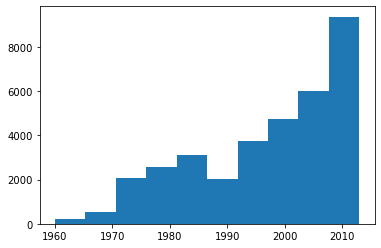

In [5]:
##checking to see distribution of non-zero(np.nan) values to determine how to impute
## will impute with mode

print(cleaned_df.construction_year.describe(), '\nMode:', cleaned_df.construction_year.replace(0.0, np.nan).mode())
plt.hist(cleaned_df.construction_year.replace(0.0, np.nan));

In [6]:
#replacing string values for status group with 0, 1, or 1 in 'status_no'
#0 target is functional, 1 target is non or needs repair (positive class for predicting)

conditions = [cleaned_df['status_group'] == 'functional', cleaned_df['status_group'] == 'functional needs repair', cleaned_df['status_group'] == 'non functional']
choices = [0, 1, 1]

cleaned_df['status_no'] = np.select(conditions, choices)
cleaned_df.drop('status_group', axis = 1, inplace = True)


In [7]:
##Separating predictor feature columns into categorical and continuous value groups
#continuous features
numerical_columns = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']
#categorical features without the target of 'status_group'
categorical_columns = cleaned_df.select_dtypes(include = 'object').columns


##Smaller amount of features to reduce computational strain - using all categoricals turned into 1600+ columns
final_columns_list = ['amount_tsh', 'longitude', 'latitude', 'construction_year', 'region_code', 'scheme_management', 'quality_group', 'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type']

numericals = ['amount_tsh', 'longitude', 'latitude', 'construction_year']
categoricals = ['region_code', 'scheme_management', 'quality_group', 'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type']


In [19]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

X = cleaned_df[final_columns_list]
y = cleaned_df['status_no']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 42)

### Transformation on the Train Set

In [20]:
X_train_cats = X_train[categoricals]
X_train_nums = X_train[numericals]

X_test_cats = X_test[categoricals]
X_test_nums = X_test[numericals]

X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [21]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        column_transformer = ColumnTransformer(transformers = [('imputer', SimpleImputer(missing_values = 0.0, strategy = 'most_frequent'), ['construction_year']),                     
                                                      ('ohe', OneHotEncoder( sparse = False, handle_unknown = 'ignore'), categoricals),
                                                      ('scaler', StandardScaler(), numericals)], 
                                                      n_jobs = -1)
        X_new = column_transformer.fit_transform(X_)
        return X_new
        

In [22]:
logreg_pipe = Pipeline(steps =[('transform', CustomTransformer()),('smote', SMOTE()),('logreg', LogisticRegression())])
bernoulli_pipe = Pipeline(steps =[('transform', CustomTransformer()),('smote', SMOTE()),('bern', BernoulliNB())])
knn_pipe = Pipeline(steps =[('transform', CustomTransformer()),('smote', SMOTE()),('knn', KNeighborsClassifier())])
tree_pipe = Pipeline(steps =[('transform', CustomTransformer()),('smote', SMOTE()),('tree', DecisionTreeClassifier())])
forest_pipe = Pipeline(steps =[('transform', CustomTransformer()),('smote', SMOTE()),('forest', RandomForestClassifier())])
xgb_pipe = Pipeline(steps =[('transform', CustomTransformer()),('smote', SMOTE()),('xgb', XGBClassifier())])


In [36]:
log_params = {
    'max_iter':[1200], 
    'penalty':['l1', 'l2', 'elasticnet'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }
                       
bernoulli_params = {'alpha': list(np.linspace(0,1, 10))}

knn_params = {
    'n_neighbors': list(range(2, 16)), 
    'weights':['uniform', 'distance'], 
    'p':list(range(1,6)) 
             }
tree_params = {
    'criterion':['gini', 'entropy'], 
    'splitter': ['best', 'random'], 
    'max_depth':list(range(10, 50)),
    'min_samples_leaf':list(range(1,5)), 
    'max_features': ['auto', 'sqrt', 'log2']
              } 
forest_params = {
    'n_estimators':list(np.linspace(10, 100, 10)),
    'criterion':['gini', 'entropy'], 
    'max_depth':list(range(10, 50)), 
    'min_samples_leaf':list(range(1,5)), 
    'max_features': ['auto', 'sqrt', 'log2']
                }

xgb_params = {
    'eta':list(np.linspace(.01, .31, 3)), 
    'min_child_weight': list(np.linspace(.5, 1.5, 3)), 
    'max_depth':list(range(3,11)), 
    'subsample':list(np.linspace(.5, 1, 6)), 
    'lambda':list(np.linspace(0, 1.5, 16)), 
    'alpha': list(np.linspace(0, 1.5, 16))
             } 

In [37]:
pipelines_list = [logreg_pipe, bernoulli_pipe, knn_pipe, tree_pipe, forest_pipe, xgb_pipe]
parameters_list = [log_params, bernoulli_params, knn_params, tree_params, forest_params, xgb_params]

In [38]:
#for pipeline, param_grid in zip(pipelines_list, parameters_list):
#    pipeline.fit(X_train, y_train)
#    gridsearch = GridSearchCV(estimator=pipeline, param_grid=param_grid)
#    gridsearch.fit(X_train, y_train)
#    print(f"{pipeline}:", gridsearch.best_params_)

C:\Users\svett\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Invalid parameter max_iter for estimator Pipeline(steps=[('transform', CustomTransformer()), ('smote', SMOTE()),
                ('logreg', LogisticRegression())]). Check the list of available parameters with `estimator.get_params().keys()`.

## First Model with Cleaned Data - Logistic Regression

In [67]:
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform', CustomTransformer()), ('smote', SMOTE()),
                ('logreg', LogisticRegression(max_iter=1200))])

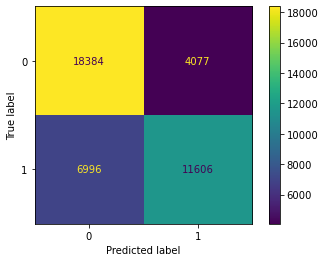

In [68]:
plot_confusion_matrix(logreg_pipe, X_train, y_train)

In [69]:
print("Score:", logreg_pipe.score(X_train, y_train))

Score: 0.7303411830601758


## Second Model - K Nearest Neighbors

In [75]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform', CustomTransformer()), ('smote', SMOTE()),
                ('knn', KNeighborsClassifier())])

In [76]:
knn_pipe.score(X_train, y_train)

0.8563913985826657

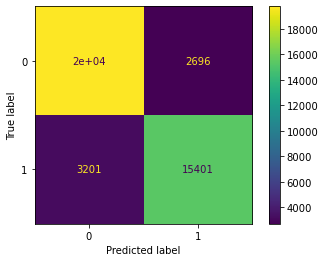

In [78]:
plot_confusion_matrix(knn_pipe, X_train, y_train)

## Third Model - Decision Tree Classifier

In [79]:
tree_pipe.fit(X_train, y_train)
tree_pipe.score(X_train, y_train)

0.9933273263034849

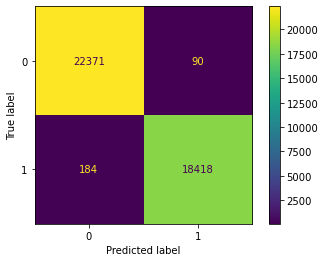

In [81]:
plot_confusion_matrix(tree_pipe, X_train, y_train)

## Model Four - XGB Classifier

In [85]:
xgb_pipe.fit(X_train, y_train)

xgb_y_preds = xgb_pipe.predict(X_train)

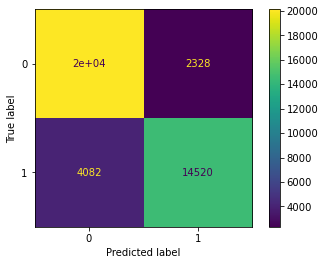

In [86]:
plot_confusion_matrix(xgb_pipe, X_train, y_train)

In [88]:
recall_score(xgb_y_preds, y_train)

0.8618233618233618

## Gridsearching through models

In [ ]:

#for pipeline, param_grid in zip(pipelines_list, parameters_list):
#    gridsearch = GridSearchCV(estimator=pipeline, param_grid=param_grid)
#    gridsearch.fit(X_train, y_train)
#    print("{pipeline}:", gridsearch.best_params_)

### Goals for Tuesday: GridsearchCV, Pipelines